In [47]:
import time
from pynq import Overlay
import numpy as np
from pynq import Xlnk
import struct
from scipy.misc import imread
import cv2
import gzip
import numpy as np
import matplotlib.pyplot as plt

In [48]:
def readbinfile(filename,size):
    z = []
    with open(filename, "r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            z.append(float(line))
        z = np.array(z)
            
#     f = open(filename, "rb")
#     z=[]
#     for j in range(size):
#         data = f.read(4)
#         if len(data) != 4:
#             continue
#         data_float = struct.unpack("f", data)[0]
#         z.append(data_float)
#     f.close()
#     z = np.array(z)
    return z

In [49]:
def RunConv(conv, K, S, pd, relu, feature_in,W,bias,feature_out):
    conv.write(0x10,feature_in.shape[2])
    conv.write(0x18,feature_out.shape[2])
    conv.write(0x20,feature_in.shape[0])
    conv.write(0x28,feature_in.shape[1])
    conv.write(0x30,K)
    conv.write(0x38,S)
    conv.write(0x40,relu)
    conv.write(0x48,pd)
    conv.write(0x50,feature_in.physical_address)
    conv.write(0x58,W.physical_address)
    conv.write(0x60,bias.physical_address)
    conv.write(0x68,feature_out.physical_address)
    conv.write(0, (conv.read(0)&0x80)|0x01 )
    tp=conv.read(0)
    while not ((tp>>1)&0x1):
        tp=conv.read(0)
    #print(tp);

In [50]:
def RunPool(pool,K, mode,feature_in,feature_out):
    pool.write(0x10,feature_in.shape[2])
    pool.write(0x18,feature_in.shape[0])
    pool.write(0x20,feature_in.shape[1])
    pool.write(0x28,K)
    pool.write(0x30,mode)
    pool.write(0x38,feature_in.physical_address)
    pool.write(0x40,feature_out.physical_address)
    pool.write(0, (pool.read(0)&0x80)|0x01 )
    while not ((pool.read(0)>>1)&0x1):
        pass

In [51]:
def RunConv1(conv,Kx,Ky,Sx,Sy,mode,relu_en,feature_in,W,bias,feature_out):
    conv.write(0x10,feature_in.shape[2])
    conv.write(0x18,feature_in.shape[0])
    conv.write(0x20,feature_in.shape[1])
    conv.write(0x28,feature_out.shape[2])
    conv.write(0x30,Kx)
    conv.write(0x38,Ky)
    conv.write(0x40,Sx)
    conv.write(0x48,Sy)
    conv.write(0x50,mode)
    conv.write(0x58,relu_en)
    conv.write(0x60,feature_in.physical_address)
    conv.write(0x68,W.physical_address)
    conv.write(0x70,bias.physical_address)
    conv.write(0x78,feature_out.physical_address)
    conv.write(0, (conv.read(0)&0x80)|0x01 )
    tp=conv.read(0)
    while not ((tp>>1)&0x1):
        tp=conv.read(0)
    #print(tp);


# In[34]:


def RunPool1(pool,Kx,Ky,mode,feature_in,feature_out):
    pool.write(0x10,feature_in.shape[2])
    pool.write(0x18,feature_in.shape[0])
    pool.write(0x20,feature_in.shape[1])
    pool.write(0x28,Kx)
    pool.write(0x30,Ky)
    pool.write(0x38,mode)
    pool.write(0x40,feature_in.physical_address)
    pool.write(0x48,feature_out.physical_address)
    pool.write(0, (pool.read(0)&0x80)|0x01 )
    while not ((pool.read(0)>>1)&0x1):
        pass

In [52]:
#Conv1
IN_WIDTH1  = 28
IN_HEIGHT1 = 28
IN_CH1     = 1

KERNEL_WIDTH1  = 5
KERNEL_HEIGHT1 = 5
X_STRIDE1      = 1
Y_STRIDE1      = 1

RELU_EN1 = 1
MODE1    = 0    #0:VALID, 1:SAME

if(MODE1):
    X_PADDING1=int((KERNEL_WIDTH1-1)/2)
    Y_PADDING1=int((KERNEL_HEIGHT1-1)/2)
else:
    X_PADDING1=0
    Y_PADDING1=0

OUT_CH1     = 16
OUT_WIDTH1  = int((IN_WIDTH1+2*X_PADDING1-KERNEL_WIDTH1)/X_STRIDE1+1)
OUT_HEIGHT1 = int((IN_HEIGHT1+2*Y_PADDING1-KERNEL_HEIGHT1)/Y_STRIDE1+1)


In [53]:
#Pool1
MODE11      = 0
IN_WIDTH11  = OUT_WIDTH1
IN_HEIGHT11 = OUT_HEIGHT1
IN_CH11     = OUT_CH1

KERNEL_WIDTH11=2
KERNEL_HEIGHT11=2

OUT_CH11=IN_CH11
OUT_WIDTH11=int(IN_WIDTH11/KERNEL_WIDTH11)
OUT_HEIGHT11=int(IN_HEIGHT11/KERNEL_HEIGHT11)

In [54]:
#Conv2
IN_WIDTH2=OUT_WIDTH11
IN_HEIGHT2=OUT_HEIGHT11
IN_CH2=OUT_CH11

KERNEL_WIDTH2=5
KERNEL_HEIGHT2=5
X_STRIDE2 = 1
Y_STRIDE2 = 1

RELU_EN2 = 1
MODE2    = 0  #0:VALID, 1:SAME
if(MODE2):
    X_PADDING2=int((KERNEL_WIDTH2-1)/2)
    Y_PADDING2=int((KERNEL_HEIGHT2-1)/2)
else:
    X_PADDING2=0
    Y_PADDING2=0

OUT_CH2=32
OUT_WIDTH2=int((IN_WIDTH2+2*X_PADDING2-KERNEL_WIDTH2)/X_STRIDE2+1)
OUT_HEIGHT2=int((IN_HEIGHT2+2*Y_PADDING2-KERNEL_HEIGHT2)/Y_STRIDE2+1)


In [55]:
#Pool2
MODE21 = 0
IN_WIDTH21=OUT_WIDTH2
IN_HEIGHT21=OUT_HEIGHT2
IN_CH21=OUT_CH2

KERNEL_WIDTH21=2
KERNEL_HEIGHT21=2

OUT_CH21=IN_CH21
OUT_WIDTH21=int(IN_WIDTH21/KERNEL_WIDTH21)
OUT_HEIGHT21=int(IN_HEIGHT21/KERNEL_HEIGHT21)

In [56]:
#Fc1
IN_WIDTH3=OUT_WIDTH21
IN_HEIGHT3=OUT_HEIGHT21
IN_CH3=OUT_CH21

KERNEL_WIDTH3=4
KERNEL_HEIGHT3=4
X_STRIDE3=4
Y_STRIDE3=4

RELU_EN3=1
MODE3=0  #0:VALID, 1:SAME
if(MODE3):
    X_PADDING3=int((KERNEL_WIDTH3-1/2))
    Y_PADDING3=int((KERNEL_HEIGHT3-1)/2)
else:
    X_PADDING3=0
    Y_PADDING3=0

OUT_CH3=128
OUT_WIDTH3=int((IN_WIDTH3+2*X_PADDING3-KERNEL_WIDTH3)/X_STRIDE3+1)
OUT_HEIGHT3=int((IN_HEIGHT3+2*Y_PADDING3-KERNEL_HEIGHT3)/Y_STRIDE3+1)

print(OUT_WIDTH3)

1


In [57]:
#Fc2
IN_WIDTH4=OUT_WIDTH3
IN_HEIGHT4=OUT_HEIGHT3
IN_CH4=OUT_CH3

KERNEL_WIDTH4=1
KERNEL_HEIGHT4=1
X_STRIDE4=1
Y_STRIDE4=1

RELU_EN4=1
MODE4=0  #0:VALID, 1:SAME
if(MODE4):
    X_PADDING4=int((KERNEL_WIDTH4-1/2))
    Y_PADDING4=int((KERNEL_HEIGHT4-1)/2)
else:
    X_PADDING4=0
    Y_PADDING4=0

OUT_CH4=10
OUT_WIDTH4=int((IN_WIDTH4+2*X_PADDING4-KERNEL_WIDTH4)/X_STRIDE4+1)
OUT_HEIGHT4=int((IN_HEIGHT4+2*Y_PADDING4-KERNEL_HEIGHT4)/Y_STRIDE4+1)
print(IN_WIDTH4)

1


In [58]:
xlnk=Xlnk()

ol=Overlay("/home/xilinx/jupyter_notebooks/CNN/hw/cnn_v3.bit")
ol.ip_dict
ol.download()
conv=ol.Conv_0
pool=ol.Pooling_0

print("Overlay download finish");  


Overlay download finish


In [59]:
#input image
image=xlnk.cma_array(shape=(IN_HEIGHT1,IN_WIDTH1,IN_CH1),cacheable=0,dtype=np.float32)

#conv1
w_conv1=xlnk.cma_array(shape=(KERNEL_HEIGHT1,KERNEL_WIDTH1,IN_CH1,OUT_CH1),cacheable=0,dtype=np.float32)
b_conv1=xlnk.cma_array(shape=(OUT_CH1),cacheable=0,dtype=np.float32)
h_conv1=xlnk.cma_array(shape=(OUT_HEIGHT1,OUT_WIDTH1,OUT_CH1),cacheable=0,dtype=np.float32)
h_pool1=xlnk.cma_array(shape=(OUT_HEIGHT11,OUT_WIDTH11,OUT_CH11),cacheable=0,dtype=np.float32)

#conv2
w_conv2=xlnk.cma_array(shape=(KERNEL_HEIGHT2,KERNEL_WIDTH2,IN_CH2,OUT_CH2),cacheable=0,dtype=np.float32)
b_conv2=xlnk.cma_array(shape=(OUT_CH2),cacheable=0,dtype=np.float32)
h_conv2=xlnk.cma_array(shape=(OUT_HEIGHT2,OUT_WIDTH2,OUT_CH2),cacheable=0,dtype=np.float32)
h_pool2=xlnk.cma_array(shape=(OUT_HEIGHT21,OUT_WIDTH21,OUT_CH21),cacheable=0,dtype=np.float32)

#fc1
w_fc1=xlnk.cma_array(shape=(KERNEL_HEIGHT3, KERNEL_WIDTH3, IN_CH3, OUT_CH3),cacheable=0,dtype=np.float32)
b_fc1=xlnk.cma_array(shape=(OUT_CH3),cacheable=0,dtype=np.float32)
h_fc1=xlnk.cma_array(shape=(OUT_HEIGHT3,OUT_WIDTH3,OUT_CH3),cacheable=0,dtype=np.float32)

#fc2
w_fc2=xlnk.cma_array(shape=(KERNEL_HEIGHT4, KERNEL_WIDTH4, IN_CH4, OUT_CH4),cacheable=0,dtype=np.float32)
b_fc2=xlnk.cma_array(shape=(OUT_CH4),cacheable=0,dtype=np.float32)
h_fc2=xlnk.cma_array(shape=(OUT_HEIGHT4,OUT_WIDTH4,OUT_CH4),cacheable=0,dtype=np.float32)

In [60]:

#Initialize W, bias
W_conv1=readbinfile("/home/xilinx/jupyter_notebooks/CNN/data/record/W_conv1.dat",KERNEL_HEIGHT1*KERNEL_WIDTH1*IN_CH1*OUT_CH1)
W_conv1=W_conv1.reshape((KERNEL_HEIGHT1,KERNEL_WIDTH1,IN_CH1,OUT_CH1))
for i in range(KERNEL_HEIGHT1):
    for j in range(KERNEL_WIDTH1):
        for k in range(IN_CH1):
        	for l in range(OUT_CH1):
        		w_conv1[i][j][k][l]=W_conv1[i][j][k][l]
                
B_conv1=readbinfile("/home/xilinx/jupyter_notebooks/CNN/data/record/b_conv1.dat",OUT_CH1)
for i in range(OUT_CH1):
	b_conv1[i]=B_conv1[i]
print(b_conv1)

W_conv2=readbinfile("/home/xilinx/jupyter_notebooks/CNN/data/record/W_conv2.dat",KERNEL_HEIGHT2*KERNEL_WIDTH2*IN_CH2*OUT_CH2)
W_conv2=W_conv2.reshape((KERNEL_HEIGHT2,KERNEL_WIDTH2,IN_CH2,OUT_CH2))
for i in range(KERNEL_HEIGHT2):
    for j in range(KERNEL_WIDTH2):
        for k in range(IN_CH2):
        	for l in range(OUT_CH2):
        		w_conv2[i][j][k][l]=W_conv2[i][j][k][l]
                
B_conv2=readbinfile("/home/xilinx/jupyter_notebooks/CNN/data/record/b_conv2.dat",OUT_CH2)
for i in range(OUT_CH2):
	b_conv2[i]=B_conv2[i]

W_fc1=readbinfile("/home/xilinx/jupyter_notebooks/CNN/data/record/W_fc1.dat",KERNEL_HEIGHT3*KERNEL_WIDTH3*IN_CH3*OUT_CH3)
W_fc1=W_fc1.reshape((KERNEL_HEIGHT3,KERNEL_WIDTH3,IN_CH3,OUT_CH3))
for i in range(KERNEL_HEIGHT3):
    for j in range(KERNEL_WIDTH3):
        for k in range(IN_CH3):
            for l in range(OUT_CH3):
                w_fc1[i][j][k][l]=W_fc1[i][j][k][l]
                
B_fc1=readbinfile("/home/xilinx/jupyter_notebooks/CNN/data/record/b_fc1.dat",OUT_CH3)
for i in range(OUT_CH3):
    b_fc1[i]=B_fc1[i]

W_fc2=readbinfile("/home/xilinx/jupyter_notebooks/CNN/data/record/W_fc2.dat",KERNEL_HEIGHT4*KERNEL_WIDTH4*IN_CH4*OUT_CH4)
W_fc2=W_fc2.reshape((KERNEL_HEIGHT4,KERNEL_WIDTH4,IN_CH4,OUT_CH4))
for i in range(KERNEL_HEIGHT4):
    for j in range(KERNEL_WIDTH4):
        for k in range(IN_CH4):
            for l in range(OUT_CH4):
                w_fc2[i][j][k][l]=W_fc2[i][j][k][l]
                
B_fc2=readbinfile("/home/xilinx/jupyter_notebooks/CNN/data/record/b_fc2.dat",OUT_CH4)
for i in range(OUT_CH4):
	b_fc2[i]=B_fc2[i]

print("Finish initial")


[ 0.0871691  0.0857268  0.0926211  0.0884191  0.114353   0.0959889  0.16029
  0.125864   0.124942   0.123752   0.116943   0.0908626  0.151391
  0.0930964  0.0951322  0.083176 ]
Finish initial


In [61]:
def load_mnist_images(file_path):
    with gzip.open(file_path, 'rb') as f:
        # 读取文件的头部信息
        magic_number = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        
        # 检查文件格式
        if magic_number != 2051:
            raise ValueError("This is not a valid MNIST image file!")
        
        # 读取图像数据
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

In [62]:
def load_mnist_labels(file_path):
    with gzip.open(file_path, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')
        
        # 检查文件格式
        if magic_number != 2049:
            raise ValueError("This is not a valid MNIST label file!")
        
        # 读取标签数据
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
    return labels

In [63]:
def visualize_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [64]:
def test_conv():
    timage=xlnk.cma_array(shape=(5,5,1),cacheable=0,dtype=np.float32)
    tw_conv1=xlnk.cma_array(shape=(3,3,1,1),cacheable=0,dtype=np.float32)
    tb_conv1=xlnk.cma_array(shape=(1),cacheable=0,dtype=np.float32)
    
    th_conv1=xlnk.cma_array(shape=(3,3,1),cacheable=0,dtype=np.float32)
    th_conv2=xlnk.cma_array(shape=(3,3,1),cacheable=0,dtype=np.float32)
    
    for i in range(5):
        for j in range(5):
            for cin in range(1):
                timage[i][j][cin] = i * 5 + j
                
    for i in range(3):
        for j in range(3):
            for k in range(1):
                for l in range(1):
                    tw_conv1[i][j][k][l] = 1
    
    for i in range(1):
        tb_conv1[i] = 0
    
    RunConv(conv,3,1,0,0,timage,tw_conv1,tb_conv1,th_conv1)
    print(th_conv1)
    
    # RunConv1(conv1,3,3,1,1,0,0,timage,tw_conv1,tb_conv1,th_conv2)
    # print(th_conv2)
    
    # RunConv(conv,KERNEL_WIDTH1,KERNEL_HEIGHT1,X_STRIDE1,Y_STRIDE1,MODE1,RELU_EN1,image,W_conv1,b_conv1,h_conv1)

                
test_conv() 

[[[  54.]
  [  63.]
  [  72.]]

 [[  99.]
  [ 108.]
  [ 117.]]

 [[ 144.]
  [ 153.]
  [ 162.]]]


In [65]:
def test_pool():
    inputsize = 4
    outputsize = inputsize // 2
    ch = 3
    feature_in=xlnk.cma_array(shape=(inputsize,inputsize,ch),cacheable=0,dtype=np.float32)
    feature_out=xlnk.cma_array(shape=(outputsize,outputsize,ch),cacheable=0,dtype=np.float32)
    
    for i in range(inputsize):
        for j in range(inputsize):
            for cin in range(ch):
                feature_in[i][j][cin] = i * inputsize * inputsize+ j * inputsize + cin
                
    RunPool(pool, 2, 0, feature_in, feature_out)
    
    # RunPool(pool, KERNEL_WIDTH11, KERNEL_HEIGHT11, MODE11, h_conv1, h_pool1)
    print(feature_out)

                
test_pool() 

[[[ 20.  21.  22.]
  [ 28.  29.  30.]]

 [[ 52.  53.  54.]
  [ 60.  61.  62.]]]


Loaded 10000 images with size 28x28.
10000


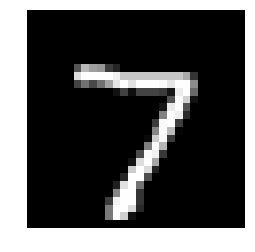

7


In [66]:
mnist = "/home/xilinx/jupyter_notebooks/CNN/data/t10k-images-idx3-ubyte.gz"
images = load_mnist_images(mnist)
print(f"Loaded {images.shape[0]} images with size {images.shape[1]}x{images.shape[2]}.")

test_label = "/home/xilinx/jupyter_notebooks/CNN/data/t10k-labels-idx1-ubyte.gz"
labels = load_mnist_labels(test_label)
print(len(labels))

# 可视化第一张图像
visualize_image(images[0])
print(labels[0])

In [72]:
def test(index):
    test_image = images[index]
    # visualize_image(images[index])
    # print("Read image")
    test_image=test_image.reshape((IN_HEIGHT1,IN_WIDTH1,IN_CH1))
    for i in range(IN_HEIGHT1):
        for j in range(IN_WIDTH1):
            for k in range(IN_CH1):
                image[i][j][k]=(test_image[i][j])/255
                
    #conv1
    RunConv(conv, KERNEL_WIDTH1,X_STRIDE1,MODE1,RELU_EN1,image,w_conv1,b_conv1,h_conv1)
    RunPool(pool, KERNEL_WIDTH11, MODE11, h_conv1, h_pool1)
    # conv2
    RunConv(conv, KERNEL_WIDTH2, X_STRIDE2, MODE2, RELU_EN2, h_pool1, w_conv2, b_conv2,h_conv2)
    RunPool(pool, KERNEL_WIDTH21, MODE21, h_conv2, h_pool2)
    # fc1
    RunConv(conv, KERNEL_WIDTH3, X_STRIDE3, MODE3, RELU_EN3, h_pool2, w_fc1, b_fc1,h_fc1)
    # fc2
    RunConv(conv, KERNEL_WIDTH4, X_STRIDE4, MODE4, RELU_EN4, h_fc1, w_fc2, b_fc2,h_fc2)  
    
    MAX = h_fc2[0][0][0]
    
    result=0
    for i in range(1,OUT_CH4):
        if(h_fc2[0][0][i]>MAX):
            MAX=h_fc2[0][0][i]
            result=i
            
#     print(h_fc2)   
#     print("The number you write is "+str(result))
    if result == labels[index]:
        return True
    else:
        return False
    
print(test(5))

True


In [69]:
def RunConv1(conv,Kx,Ky,Sx,Sy,mode,relu_en,feature_in,W,bias,feature_out):
    conv.write(0x10,feature_in.shape[2])
    conv.write(0x18,feature_in.shape[0])
    conv.write(0x20,feature_in.shape[1])
    conv.write(0x28,feature_out.shape[2])
    conv.write(0x30,Kx)
    conv.write(0x38,Ky)
    conv.write(0x40,Sx)
    conv.write(0x48,Sy)
    conv.write(0x50,mode)
    conv.write(0x58,relu_en)
    conv.write(0x60,feature_in.physical_address)
    conv.write(0x68,W.physical_address)
    conv.write(0x70,bias.physical_address)
    conv.write(0x78,feature_out.physical_address)
    conv.write(0, (conv.read(0)&0x80)|0x01 )
    tp=conv.read(0)
    while not ((tp>>1)&0x1):
        tp=conv.read(0)
    #print(tp);


# In[34]:


def RunPool1(pool,Kx,Ky,mode,feature_in,feature_out):
    pool.write(0x10,feature_in.shape[2])
    pool.write(0x18,feature_in.shape[0])
    pool.write(0x20,feature_in.shape[1])
    pool.write(0x28,Kx)
    pool.write(0x30,Ky)
    pool.write(0x38,mode)
    pool.write(0x40,feature_in.physical_address)
    pool.write(0x48,feature_out.physical_address)
    pool.write(0, (pool.read(0)&0x80)|0x01 )
    while not ((pool.read(0)>>1)&0x1):
        pass

In [73]:
right = 0
test_sum = 1000
start_time = time.time()
for i in range(test_sum):
    if test(i):
        right = right + 1
print(right/test_sum)
end_time = time.time()
execution_time = end_time - start_time
print(f"函数执行时间: {execution_time} 秒")


0.956
函数执行时间: 1888.187489271164 秒
